# Image segmentation using FCN-8 decoder

An example of image segmentation of hand written digits using m2nist dataset.

In [1]:
import tensorflow as tf
import tensorflow_datasets as tfds

import numpy as np
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split

import PIL
import os
import zipfile

## 1. Dataset

### 1.1 Download and unpack the dataset

In [2]:
!wget --no-check-certificate https://storage.googleapis.com/tensorflow-1-public/tensorflow-3-temp/m2nist.zip -O /tmp/m2nist.zip

--2023-05-21 01:10:23--  https://storage.googleapis.com/tensorflow-1-public/tensorflow-3-temp/m2nist.zip
Resolving storage.googleapis.com (storage.googleapis.com)... 172.253.117.128, 142.250.99.128, 173.194.202.128, ...
Connecting to storage.googleapis.com (storage.googleapis.com)|172.253.117.128|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 17378168 (17M) [application/zip]
Saving to: ‘/tmp/m2nist.zip’

/tmp/m2nist.zip     100%[===================>]  16.57M  84.0MB/s    in 0.2s    

2023-05-21 01:10:23 (84.0 MB/s) - ‘/tmp/m2nist.zip’ saved [17378168/17378168]



In [3]:
ZIP_DIR = '/tmp/m2nist.zip'
DATASET_DIR = '/dataset'

with zipfile.ZipFile(ZIP_DIR, 'r') as unpack:
    unpack.extractall(DATASET_DIR)

### 1.2 Load dataset to notebook
Dataset is stored as two Numpy files for images and segmentation masks.
- **Images** 64x84 images with multiple digits.
- **Segmentation** 64x84 images with segmentation masks for 0-9 digits and background.

There are 5000 records total.

In [4]:
def preprocess_dataset(image, mask):

    image = tf.cast(image, dtype='float32')
    image /= 255
    image = tf.expand_dims(image, axis=-1)

    mask = tf.cast(mask, dtype='int32')

    return image, mask


def create_datasets(images_dir, segmentation_dir):

    images = np.load(images_dir)
    segmentation = np.load(segmentation_dir)

    print(f"Images shape: {images.shape}\nSegmentation shape: {segmentation.shape}")

    train_img, val_img, train_seg, val_seg = train_test_split(images, segmentation, test_size=0.2, shuffle=True)
    val_img, test_img, val_seg, test_seg = train_test_split(val_img, val_seg, test_size=0.2, shuffle=True)

    print(f'\nDatasets size:\nTrain: {train_img.shape[0]}\tTest: {test_img.shape[0]}\tVal: {val_img.shape[0]}')

    train_dataset = tf.data.Dataset.from_tensor_slices((train_img, train_seg)).shuffle(512).batch(BATCH_SIZE)
    test_dataset = tf.data.Dataset.from_tensor_slices((test_img, test_seg)).shuffle(512).batch(BATCH_SIZE, drop_remainder=True)
    val_dataset = tf.data.Dataset.from_tensor_slices((val_img, val_seg)).shuffle(512).batch(BATCH_SIZE)

    train_dataset = train_dataset.map(preprocess_dataset)
    test_dataset = test_dataset.map(preprocess_dataset)
    val_dataset = val_dataset.map(preprocess_dataset)

    return train_dataset, test_dataset, val_dataset

### 1.3 Create the train, test and validation datasets

In [5]:
IMAGES_DIR = f'{DATASET_DIR}/combined.npy'
SEGMENTATION_DIR = f'{DATASET_DIR}/segmented.npy'
CLASSES_AMOUNT = 11
BATCH_SIZE = 32

print(f"Loading dataset...\nNumber of classes: {CLASSES_AMOUNT}\n")

train_dataset, test_dataset, val_dataset = create_datasets(IMAGES_DIR, SEGMENTATION_DIR)

Loading dataset...
Number of classes: 11

Images shape: (5000, 64, 84)
Segmentation shape: (5000, 64, 84, 11)

Datasets size:
Train: 4000	Test: 200	Val: 800


### 1.4 Preview sample images

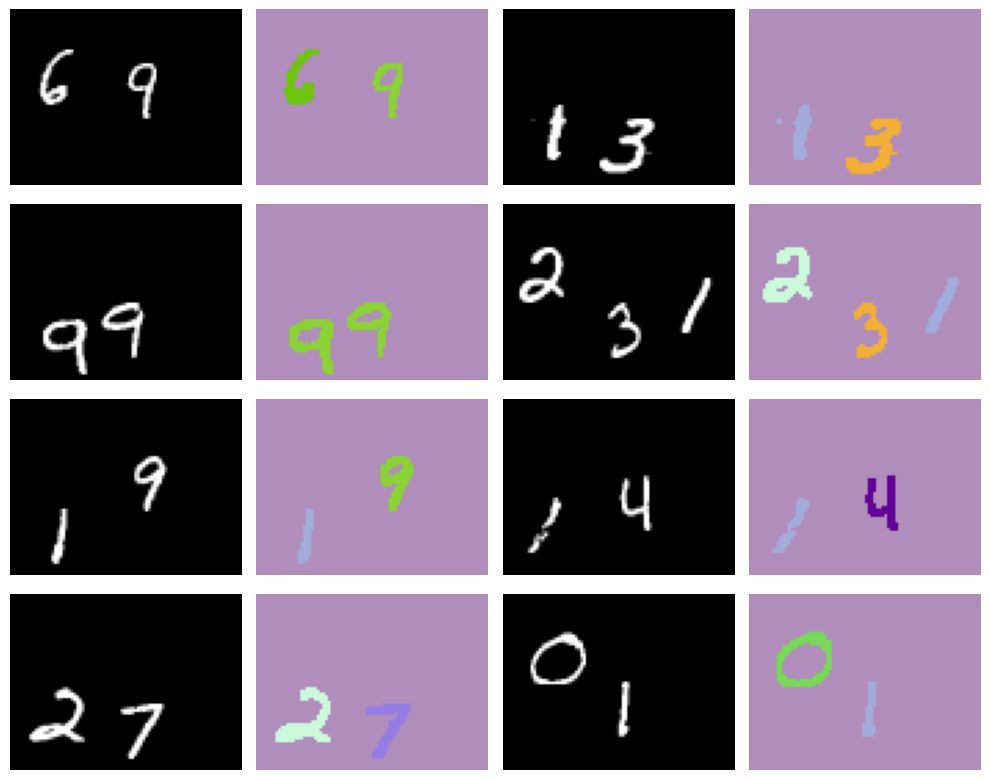

In [6]:
colors = [tuple(np.random.randint(256, size=3) / 255.0) for i in range(CLASSES_AMOUNT)]

def convert_mask_to_image(mask):

    seg_img = np.zeros( (mask.shape[0],mask.shape[1], 3) ).astype('float')

    for c in range(CLASSES_AMOUNT):
        segc = (mask == c)
        seg_img[:,:,0] += segc*( colors[c][0] * 255.0)
        seg_img[:,:,1] += segc*( colors[c][1] * 255.0)
        seg_img[:,:,2] += segc*( colors[c][2] * 255.0)

    return seg_img.astype('uint8')


def preview_dataset(dataset, amount):

    cols = 4
    rows = 2

    fig, axs = plt.subplots(nrows=rows * 2, ncols=cols, figsize=(10, 8))

    for i, data in enumerate(dataset.take(amount)):
        image, mask = data
        merged_mask = np.argmax(mask, axis=3)
        merged_mask = convert_mask_to_image(merged_mask[0])

        img_index = (i*2)
        seg_index = img_index + 1

        axs[img_index // cols, img_index % cols].imshow(image[0], cmap='gray')
        axs[img_index // cols, img_index % cols].axis('off')

        axs[seg_index // cols, seg_index % cols].imshow(merged_mask)
        axs[seg_index // cols, seg_index % cols].axis('off')

    fig.tight_layout()
    fig.show()


preview_dataset(train_dataset, amount=8)

## 2. FCN

### 2.1 Downsampling path

**Convolutional block**

In [7]:
IMAGE_ORDERING = 'channels_last'

def conv_block(input, filters, kernel_size, pooling_size, pool_strides, index):
    x = tf.keras.layers.Conv2D(filters, kernel_size, padding='same', data_format=IMAGE_ORDERING)(input)
    x = tf.keras.layers.LeakyReLU()(x)
    x = tf.keras.layers.Conv2D(filters, kernel_size, padding='same', data_format=IMAGE_ORDERING)(x)
    x = tf.keras.layers.LeakyReLU()(x)
    x = tf.keras.layers.MaxPooling2D(pooling_size)(x)
    x = tf.keras.layers.BatchNormalization(name=f"END_OF_CONVBLOCK_{index}")(x)

    return x

In [8]:
def FCN8(input_height=64, input_width=84):
    img_input = tf.keras.layers.Input(shape=(input_height,input_width, 1))

    x = tf.keras.layers.ZeroPadding2D(((0, 0), (0, 96-input_width)))(img_input)

    x = conv_block(x, filters=32,   kernel_size=3,  pooling_size=2, pool_strides=2, index=1)
    x = conv_block(x, filters=64,   kernel_size=3,  pooling_size=2, pool_strides=2, index=2)
    x = conv_block(x, filters=128,  kernel_size=3,  pooling_size=2, pool_strides=2, index=3)
    f3 = x

    x = conv_block(x, filters=256,  kernel_size=3,  pooling_size=2, pool_strides=2, index=4)
    f4 = x

    x = conv_block(x, filters=256,  kernel_size=3,  pooling_size=2, pool_strides=2, index=5)
    f5 = x
  
    return (f3, f4, f5), img_input

### 2.2 Upsampling path

In [9]:
def FCN8_decoder(convs, n_classes):
    f3, f4, f5 = convs
    n = 512

    x = tf.keras.layers.Conv2D(
        n, 
        (7,7), 
        activation='relu', 
        padding='same', 
        name="conv6", 
        data_format=IMAGE_ORDERING
    )(f5)

    x = tf.keras.layers.Dropout(0.5)(x)

    x = tf.keras.layers.Conv2D(
        n, 
        (1, 1),
        activation='relu',
        padding='same', 
        name="conv7", 
        data_format=IMAGE_ORDERING
    )(x)

    x = tf.keras.layers.Dropout(0.5)(x)

    x = tf.keras.layers.Conv2D(
        n_classes,  
        (1, 1), 
        activation='relu', 
        padding='same', 
        data_format=IMAGE_ORDERING
    )(x)

    x = tf.keras.layers.Conv2DTranspose(
        n_classes, 
        kernel_size=(4,4),  
        strides=(2,2), 
        data_format=IMAGE_ORDERING,
        use_bias=False
    )(f5)

    x = tf.keras.layers.Cropping2D(cropping=(1,1))(x)

    x2 = f4
    x2 = tf.keras.layers.Conv2D(
        n_classes, 
        (1, 1), 
        activation='relu', 
        padding='same',
        data_format=IMAGE_ORDERING,
    )(x2)

    x = tf.keras.layers.Add()([x, x2])

    x = tf.keras.layers.Conv2DTranspose(
        n_classes, 
        kernel_size=(4,4),  
        strides=(2,2), 
        data_format=IMAGE_ORDERING,
        use_bias=False
    )(x)
    x = tf.keras.layers.Cropping2D(cropping=(1, 1))(x)

    x2 = f3
    x2 = tf.keras.layers.Conv2D(
        n_classes,
        (1, 1), 
        activation='relu', 
        padding='same', 
        data_format=IMAGE_ORDERING
    )(x2)

    x = tf.keras.layers.Add()([x, x2])

    x = tf.keras.layers.Conv2DTranspose(
        n_classes, 
        kernel_size=(8,8),  
        strides=(8,8), 
        data_format=IMAGE_ORDERING,
        use_bias=False
    )(x)

    x = tf.keras.layers.Cropping2D(((0, 0), (0, 96-84)))(x)

    y = (tf.keras.layers.Activation('sigmoid'))(x)

    return y


### 2.3 Complete model

In [10]:
convs, img_input = FCN8()

decoder = FCN8_decoder(convs, CLASSES_AMOUNT)

model = tf.keras.Model(inputs=img_input, outputs=decoder)

model.summary()

Model: "model"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_1 (InputLayer)           [(None, 64, 84, 1)]  0           []                               
                                                                                                  
 zero_padding2d (ZeroPadding2D)  (None, 64, 96, 1)   0           ['input_1[0][0]']                
                                                                                                  
 conv2d (Conv2D)                (None, 64, 96, 32)   320         ['zero_padding2d[0][0]']         
                                                                                                  
 leaky_re_lu (LeakyReLU)        (None, 64, 96, 32)   0           ['conv2d[0][0]']                 
                                                                                              

## 3. Train model

### 3.1 Compile the model

In [11]:
model.compile(
    loss='categorical_crossentropy', 
    optimizer='adam', 
    metrics=['accuracy']
)

### 3.2 Train the model

In [12]:
EPOCHS = 20

early_stopping = tf.keras.callbacks.EarlyStopping(monitor='val_accuracy', patience=5)

history = model.fit(train_dataset, batch_size=BATCH_SIZE, epochs=EPOCHS, validation_data=val_dataset, callbacks=[early_stopping])



Epoch 1/20
125/125 [==============================] - 23s 41ms/step - loss: 0.5276 - accuracy: 0.8552 - val_loss: 0.6171 - val_accuracy: 0.9417
Epoch 2/20
125/125 [==============================] - 4s 35ms/step - loss: 0.2134 - accuracy: 0.9427 - val_loss: 0.3210 - val_accuracy: 0.9417
Epoch 3/20
125/125 [==============================] - 4s 32ms/step - loss: 0.1908 - accuracy: 0.9438 - val_loss: 0.3057 - val_accuracy: 0.9417
Epoch 4/20
125/125 [==============================] - 4s 33ms/step - loss: 0.1499 - accuracy: 0.9501 - val_loss: 0.2244 - val_accuracy: 0.9425
Epoch 5/20
125/125 [==============================] - 5s 38ms/step - loss: 0.1051 - accuracy: 0.9625 - val_loss: 0.0980 - val_accuracy: 0.9632
Epoch 6/20
125/125 [==============================] - 4s 31ms/step - loss: 0.0779 - accuracy: 0.9708 - val_loss: 0.0840 - val_accuracy: 0.9681
Epoch 7/20
125/125 [==============================] - 6s 46ms/step - loss: 0.0651 - accuracy: 0.9747 - val_loss: 0.0641 - val_accuracy: 0.974

### 3.3 Display accuracy and loss plot

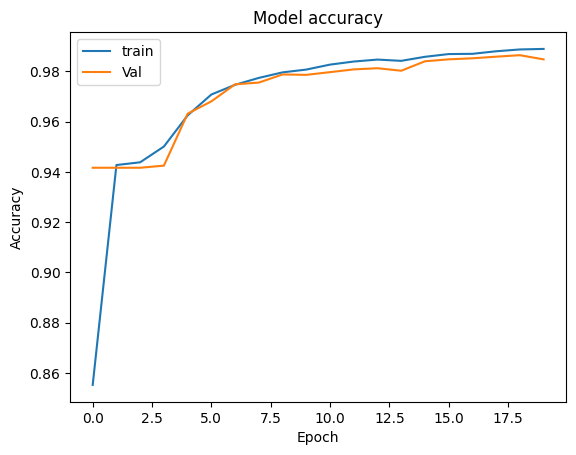

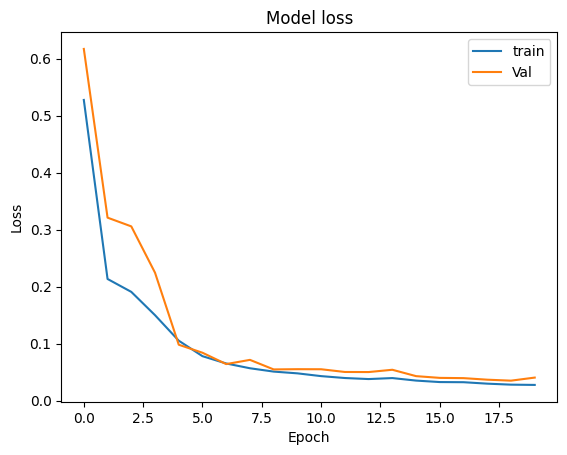

In [13]:
plt.title("Model accuracy")
plt.plot(history.history["accuracy"])
plt.plot(history.history["val_accuracy"])
plt.legend(["train", "Val"], loc="upper left")
plt.ylabel("Accuracy")
plt.xlabel("Epoch")
plt.show()

plt.title("Model loss")
plt.plot(history.history["loss"])
plt.plot(history.history["val_loss"])
plt.legend(["train", "Val"], loc="upper right")
plt.ylabel("Loss")
plt.xlabel("Epoch")
plt.show()

## 4. Evaluation

### 4.1 Get the predictions

In [14]:
results = model.predict(test_dataset)
print(results.shape)

print(results[0,0,0,0])
print(results[0,0,0,10])

6/6 [==============================] - 0s 11ms/step
(192, 64, 84, 11)
0.008147881
0.998262


### 4.2 Get the argmax of segmentation masks


In [15]:
results = np.argmax(results, axis=3)
print(results.shape)

print(results[0,0,0])

# prediction map for image 0
print(results[0,:,:])

(192, 64, 84)
10
[[10 10 10 ... 10 10 10]
 [10 10 10 ... 10 10 10]
 [10 10 10 ... 10 10 10]
 ...
 [10 10 10 ... 10 10 10]
 [10 10 10 ... 10 10 10]
 [10 10 10 ... 10 10 10]]


### 4.3 Visualize predictions

In [16]:
def visualize_prediction(image, y_true, y_pred):
    fig, axs = plt.subplots(1,3, figsize=(9,3))
    axs[0].imshow(image)
    axs[0].axis('off')
    axs[1].imshow(y_true)
    axs[1].axis('off')
    axs[2].imshow(y_pred)
    axs[2].axis('off')
    fig.show()

In [17]:
def class_wise_metrics(y_true, y_pred):

    class_wise_iou = []
    class_wise_dice_score = []

    smoothing_factor = 0.00001

    for i in range(11):
        intersection = np.sum((y_pred == i) * (y_true == i))
        y_true_area = np.sum((y_true == i))
        y_pred_area = np.sum((y_pred == i))
        combined_area = y_true_area + y_pred_area

        iou = (intersection) / (combined_area - intersection + smoothing_factor)
        class_wise_iou.append(iou)

        dice_score =  2 * ((intersection) / (combined_area + smoothing_factor))
        class_wise_dice_score.append(dice_score)

    return class_wise_iou, class_wise_dice_score

In [18]:
# unbatched_test = test_dataset.unbatch()
# unbatched_test = unbatched_test.batch(200)

# samples_amount = 10

# for img, mask in unbatched_test.take(5):
#     mask = np.argmax(mask, axis=2)
#     pred = model.predict(np.expand_dims(img, axis=0)) 
#     pred = np.argmax(pred, axis=3)

#     iou, dice_score = class_wise_metrics(mask, pred)  

#     mask = np.squeeze(mask)
#     pred = np.squeeze(pred)
    
#     for index in range(11-1):
#         if iou[index] != 0:
#             print(f'Digit {index} - IOU: {iou[index]:.4f}\tDice score: {dice_score[index]:.4f}')
            
#     visualize_prediction(img, convert_mask_to_image(mask), convert_mask_to_image(pred))
#     plt.pause(0.1)


# place a number here between 0 to 191 to pick an image from the test set
integer_slider = 155

ds = test_dataset.unbatch()
ds = ds.batch(200)
images = []

y_true_segments = []
for image, annotation in ds.take(2):
  y_true_segments = annotation
  images = image
  
  
iou, dice_score = class_wise_metrics(np.argmax(y_true_segments[integer_slider], axis=2), results[integer_slider])


### 4.3 Intersection over union and Dice score of the model

In [19]:
cls_wise_iou, cls_wise_dice_score = class_wise_metrics(np.argmax(y_true_segments, axis=3), results)

average_iou = 0.0
for idx, (iou, dice_score) in enumerate(zip(cls_wise_iou[:-1], cls_wise_dice_score[:-1])):
  print("Digit {}: IOU: {} Dice Score: {}".format(idx, iou, dice_score)) 
  average_iou += iou

grade = average_iou * 10

print("\nGrade is " + str(grade))

PASSING_GRADE = 60
if (grade>PASSING_GRADE):
  print("You passed!")
else:
  print("You failed. Please check your model and re-train")


# model_iou = []
# model_dice_score = []

# for image, mask in unbatched_test:
#     model_iou, model_dice_score = class_wise_metrics(np.argmax(mask, axis=3), results)      

# average_iou = 0.0
# for idx, (iou, dice_score) in enumerate(zip(model_iou[:-1], model_dice_score[:-1])):
#   print("Digit {}: IOU: {} Dice Score: {}".format(idx, iou, dice_score)) 
#   average_iou += iou

# grade = average_iou * 10

# print("\nGrade is " + str(grade))

# PASSING_GRADE = 60
# if (grade>PASSING_GRADE):
#   print("You passed!")
# else:
#   print("You failed. Please check your model and re-train")

Digit 0: IOU: 0.003248335225557629 Dice Score: 0.006475635416484026
Digit 1: IOU: 0.008856199326244072 Dice Score: 0.01755691114780998
Digit 2: IOU: 0.011200104179722534 Dice Score: 0.022152102503604804
Digit 3: IOU: 0.003030303027520383 Dice Score: 0.0060422960669758346
Digit 4: IOU: 0.005671942177594052 Dice Score: 0.011279905384080866
Digit 5: IOU: 0.006366225493075703 Dice Score: 0.012651906099007902
Digit 6: IOU: 0.006646695369175533 Dice Score: 0.013205617024825056
Digit 7: IOU: 0.011765680659735123 Dice Score: 0.023257718431530818
Digit 8: IOU: 0.011029059162722683 Dice Score: 0.021817491916318068
Digit 9: IOU: 0.009966169872939409 Dice Score: 0.019735650896491354

Grade is 0.7778071449428712
You failed. Please check your model and re-train
